### Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import norm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand

plt.rcParams["figure.figsize"] = (8, 5)

### Getting the data

In [2]:
def get_sp500_ticker_list():
    """
    Returns a list with all SP500 tickers
    """
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    table = tables[0]
    ticker_list = table['Symbol']
    return ticker_list

In [3]:
def get_sample_ticker(ticker_list, s=5):
    sample = ticker_list.sample(s).to_list()
    return sample

In [15]:
def get_adj_close(ticker_list, start, end, interval):
    """
    Returns the adjusted close for a unique ticker as string or a list of tickers.
    Format of dates: 'yyyy-mm-dd'
    Possible intervals: '1d', '5d', '1mo' 
    or intraday measures but limited to max a week's worth: '1m', '2m', '5m', '15m', '30m'
    """
    full_df = yf.download(ticker_list, start=start, end=end, interval=interval)
    adj_close_df = np.log(full_df['Adj Close'])
    return adj_close_df

In [28]:
def get_adj_close_df(s=5, start='2020-01-01', end='2021-12-31', interval='1d', log = False):
    """
    Returns the returns df and adj close df for a unique ticker as string or a list of tickers.
    n = sample size
    Format of dates: 'yyyy-mm-dd'
    Possible intervals: '1d', '5d', '1mo' 
    or intraday measures but limited to max a week's worth: '1m', '2m', '5m', '15m', '30m'
    Returns a dataframe of a random sample of the sp500 adj closes over a certain period of time
    """
    sp500_tickers = get_sp500_ticker_list()
    sample_tickers = get_sample_ticker(sp500_tickers, s)
    full_df = yf.download(sample_tickers, start=start, end=end, interval=interval)
    if log == True:
        adj_close_df = np.log(full_df['Adj Close'])
    else:
        adj_close_df = full_df['Adj Close']
    return adj_close_df

In [23]:
def get_returns(adj_close_df):
    df_returns = (adj_close_df.pct_change())*100
    df_returns.dropna(axis=0,inplace=True)
    return df_returns

In [24]:
def get_volatility(returns_df):
    realized_vol = returns_df.rolling(5).std()
    realized_vol.dropna(inplace=True)
    return realized_vol

### Data analysis

In [29]:
adj_close_df = get_adj_close_df(s=5, start='2020-01-01', end='2021-12-31', interval='1d', log=True)

[*********************100%***********************]  5 of 5 completed


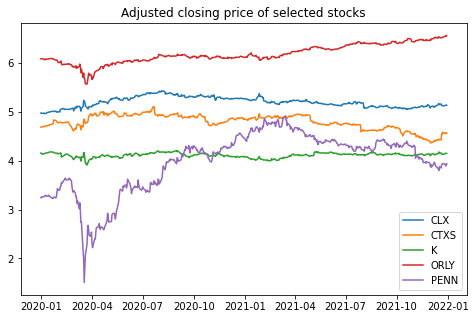

In [30]:
#plotting adjusted close price
plt.plot(adj_close_df)
plt.legend(adj_close_df.columns)
plt.title("Adjusted closing price of selected stocks")
plt.show()

In [ ]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [ ]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    
    #plots layout
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    
    #time series of return on top-left
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    
    #adding stats on top-left plot
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    #plotting qqplot on top-right
    probplot(x, plot=axes[0][1])
    
    #calculating distributions moments
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    
    #adding stats on top-right plot
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    #plot autocorrelation
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    axes[1][0].set_xlabel('Lag')
    
    #plot autocorrelation function
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Splitting the dataset by observations

In [ ]:
def split_df(df, n):
    df_test = df.iloc[-n:]
    df_train = df.iloc[:-n]
    split_date = df.iloc[-n:].index
    return df_train, df_test, split_date

In [ ]:
# Cross validation
# tscv = TimeSeriesSplit(n_splits=20, test_size=5)
# def get_train_test(df):
#     train_test_indices = {'train':{}, 'test':{}, 'split_dates': {}}
#     for i, (train_index, test_index) in enumerate(tscv.split(df)):
#         train_test_indices['train'][i] = train_index
#         train_test_indices['test'][i] = test_index
#         train_test_indices['split_dates'][i] = test_index[0]
#     return train_test_indices
# returns_splits = get_train_test(returns_df)
# volatility_splits = get_train_test(volatility_df)

### GARCH

In [ ]:
def garch(returns, n):

    aic_garch = []

    for p in range(1, 5): 
        for q in range(1, 5):
            garch = arch_model(returns, mean='zero', vol='GARCH', p=p, q=q)\
                .fit(disp='off') 
            aic_garch.append(garch.aic) 

            if garch.aic == np.min(aic_garch): 
                best_param = (p,q) 
    
    #fitting the best GARCH model
    garch = arch_model(returns, mean='zero', vol='GARCH', p=best_param[0], q=best_param[1]).fit(disp='off')

    #forecasts
    forecasts = garch.forecast(horizon=n, reindex=False)
    #forecasts = garch.forecast(horizon=50, start=split_date[0], reindex=True)
    return forecasts, forecasts.residual_variance.dropna().transpose()

In [ ]:
def get_rmse(residuals, realized_vol):
    rmse = np.sqrt(mse(realized_vol/100, np.sqrt(residuals/100)))
    return rmse

### ARCH

In [ ]:
def arch(returns, n):
    aic_arch = []

    for p in range(1, 5): # Iterating ARCH parameter p
        arch = arch_model(returns, mean='zero', vol='ARCH', p=p)\
             .fit(disp='off') # Running ARCH(p)
        aic_arch.append(arch.aic) # Storing aic for the ARCH(p)

        if arch.aic == np.min(aic_arch): 
             best_param = p # Finding the minimum AIC score
                
    # Fitting best arch
    arch = arch_model(returns, mean='zero', vol='ARCH', p=best_param)\
         .fit(disp='off')
    
    forecasts = arch.forecast(horizon=n, reindex=False)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### GJR garch

In [ ]:
def gjr_garch(returns, n):
    aic_gjr_garch = []

    for p in range(1, 5): 
        for q in range(1, 5):
            gjr_garch = arch_model(returns, mean='zero', vol='GARCH', p=p, o=1, q=q)\
                 .fit(disp='off') 
            aic_gjr_garch.append(gjr_garch.aic) 

            if gjr_garch.aic == np.min(aic_gjr_garch): 
                 best_param = p, q # Finding the minimum AIC score
    
    gjr_garch = arch_model(returns, mean='zero', vol='ARCH', p=best_param[0], o=1,
                       q=best_param[1]).fit(disp='off')
    
    forecasts = gjr_garch.forecast(horizon=n, reindex=True)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### EGARCH

In [ ]:
def egarch(returns, n):
    aic_egarch = []

    for p in range(1, 5):
        for q in range(1, 5):
            egarch = arch_model(returns, mean='zero', vol='EGARCH', p=p, q=q)\
                  .fit(disp='off')
            aic_egarch.append(egarch.aic)
            if egarch.aic == np.min(aic_egarch):
                best_param = (p, q)
    
    egarch = arch_model(returns, mean='zero', vol='EGARCH',
                        p=best_param[0], q=best_param[1], dist="skewt").fit(disp='off')
    
    forecasts = egarch.forecast(horizon=n, method='simulation', reindex=False)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### Neural nets, preprocessing

In [ ]:
def get_svm_volatility(volatility_df):
    realized_vol = {}
    for ticker in volatility_df.columns:
        realized_vol[ticker] = pd.DataFrame(volatility_df[ticker]).reset_index(drop=True)
    return realized_vol

In [ ]:
def get_svm_returns(returns_df):
    returns_svm = {}
    for ticker in returns_df.columns:
        returns_svm[ticker] = returns_df[ticker]**2
        returns_svm[ticker] = returns_svm[ticker].reset_index()
        del returns_svm[ticker]['Date']
    return returns_svm

In [ ]:
def concat_ret_vol(returns_df, volatility_df):
    Xs = {}
    realized_vol = get_svm_volatility(volatility_df)#[:-4]
    returns_svm = get_svm_returns(returns_df)
    for ticker in volatility_df.keys():
        Xs[ticker] = pd.concat([realized_vol[ticker], returns_svm[ticker][:-4]], axis=1, ignore_index=True)
        
    return Xs

In [ ]:
# def get_train_test_svm(Xs, n=50):
#     Xs_splitted = {}
#     for ticker, X in Xs.items():
#         Xs_splitted[ticker] = {}
#         Xs_splitted[ticker]['train'] = X.iloc[:-n]
#         Xs_splitted[ticker]['test'] = X.iloc[-n:]
#     return Xs_splitted

<!-- Xs_splitted = get_train_test_svm(Xs, n=50) -->

### Neural Nets

### A primer on Artificial Neural Networks

A **artificial neural network** is an interconnection of neurons such that their output is connected, with a weight, to the inputs of other neurons. The most common neural architecture is the **Multi-Layer Perceptron** (MLP). This is the one we used in this work.  
A MLP is composed of one (passthrough) **input layer**, one or more intermediate layers, called **hidden layers**, and one final layer called the **output layer**. When an ANN contains a several hidden layers, it is called a **deep neural network** (DNN). 
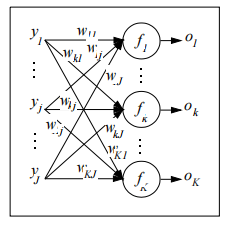
However, in our case, we will limit the theoretical presentation to a single hidden layer, because the deep neural case is just a generalisation to n-layers. 

In short an artificial neural network proceeds as follow:
- First, each neuron is fueled by some inputs. Each input is weighted by a weight $w_{kj} \quad \forall j \in \{1,...,J\}$ and $\forall k \in \{1,...,K\}$. 
- Then, the neuron acts like a processor a compute a sum of the inputs weighted their respective weight.
$$ net_k = \sum_{j=1}^J w_{kj} y_j$$
- The output $o_k$ is then given by application of an activation function $ o_k = f_k(net_k)$

But, how the optimal weights are choosen?

The **error backpropagating** algorithm is currently the most used learning algorithm. The backpropagation algorithm can find out how each connection weight and each term bias should be tweaked (adjusted) to reduce the error term (difference between predicted outputs and expected outputs). 

- For each training instance, the backpropagation algorithm first makes a prediction (forward pass) and measures the error
- It goes through each layer in reverse to measure the error contribution from each connection (backpropagation)
- Finally tweaks the connection weights to reduce the error using a Gradient steep descent.

##### Mathematical presentation of the backpropagating algorithm




The inputs and outputs can be represented by vectors:
\begin{align}
y &= \begin{bmatrix}
           y_{1} \\
           y_{2} \\
           \vdots \\
           y_{J}
         \end{bmatrix}
\end{align}

\begin{align}
o &= \begin{bmatrix}
           o_{1} \\
           o_{2} \\
           \vdots \\
           o_{K}
         \end{bmatrix}
\end{align}

... should be ended

In [ ]:
def neural_net(Xs, n, NN_vol, para_grid_NN):
    X_predictions = {}
    for ticker, X in Xs.items():
        realized_vol = X[0]
        clf = RandomizedSearchCV(NN_vol, para_grid_NN)
        clf.fit(X.iloc[:-n].values,
            realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
        X_predictions[ticker] = clf.predict(X.iloc[-n:])
    return X_predictions

### RMSES

In [ ]:
def get_rmses(s, n, start, end, interval):
    """
    s = how many companies
    n = sample size for testing
    """
    NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
    para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [15000, 30000],
                'alpha': [0.00005, 0.0005 ]}
    rmses = {}
    
    # Get data
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility for arch type models
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    
    # Splitting sets for arch type models
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    df_train_ret, df_test_ret, split_date = split_df(returns_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    
    # Getting rmses
    for ticker in df_test_vol.columns:
        rmses[ticker] = {}
        
        #Neural net
        rmses[ticker]['nn'] = np.sqrt(mse(df_test_vol[ticker] / 100, nn_predictions[ticker] / 100))
        
        #Garch
        forecasts, residuals = garch(df_train_ret[ticker], n)
        rmses[ticker]['garch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #Arch
        forecasts, residuals = garch(df_train_ret[ticker], n)
        rmses[ticker]['arch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #GJR-garch
        forecasts, residuals = gjr_garch(df_train_ret[ticker], n)
        rmses[ticker]['gjr_garch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #Egarch
        forecasts, residuals = egarch(df_train_ret[ticker], n)
        rmses[ticker]['egarch'] = get_rmse(residuals, df_test_vol[ticker])
        
    return rmses, adj_close_df

In [ ]:
sample_daily_1y, adj_close_df = get_rmses(s=5, n=5, start='2017-01-17', end='2017-03-17', interval='1d')
sample_daily_1y_df = pd.DataFrame(sample_daily_1y)
sample_daily_1y_df.to_csv('sample_daily_1y.csv')
sample_daily_1y_df = pd.read_csv('sample_daily_1y.csv', index_col=0)
sample_daily_1y_df

In [ ]:
def plot_rmse(single_stock, e, title):
    if e == 0:
        models = ['Neural Net', 'Garch', 'Arch', 'Gjr-garch', 'Egarch']
        values = single_stock
    else:
        models = ['Neural Net', 'Garch', 'Arch', 'Gjr-garch']
        values = single_stock[:-1]
        
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.barh(models, values, color="salmon", alpha=0.9)
    plt.title(title)
    plt.show()

In [ ]:
for ticker in sample_daily_1y_df.columns:
    plot_rmse(sample_daily_1y_df[ticker], 0, f'Daily volatility prediction for {ticker} RMSE/model')

In [ ]:
#sample_weekly_10y_df = pd.read_csv('sample_weekly_10y.csv', index_col=0)
#sample_weekly_10y_df

In [ ]:
for ticker in sample_weekly_10y_df.columns:
    plot_rmse(sample_weekly_10y_df[ticker], 1, f'Weekly volatility prediction for {ticker} RMSE/model')

## Application

In [ ]:
def var(s, n, start, end, interval, amount, level): 
    """
    s = how many companies
    n = sample size for testing
    """
    NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
    para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [15000, 30000],
                'alpha': [0.00005, 0.0005 ]}
    rmses = {}
    
    # Get data
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility for arch type models
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    
    # Splitting sets for arch type models
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    df_train_ret, df_test_ret, split_date = split_df(returns_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    
    #Value at risk calculation
    var_dic = {}
    values = list(nn_predictions.values())
    i=0
    
    #a = np.random.random(s)
    #weights = a/(a.sum())
    
    for key in nn_predictions:
        var = norm.ppf(level)*(values[i][-1])/np.sqrt(100)*amount#*weights[i]
        var_dic[key] = var
        i=i+1
    
    plt.bar(range(len(var_dic)), list(var_dic.values()), align='center')
    plt.xticks(range(len(var_dic)), list(var_dic.keys()))
    plt.title("1% VaR of a 5-day horizon")
    plt.show()
    
    return var_dic

In [ ]:
var = var(s=5, n=5, start='2017-01-17', end='2017-03-17', interval='1d', amount=1000000, level=0.99)

In [ ]:
var

In [ ]:
# Get data
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility for arch type models
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    
    # Splitting sets for arch type models
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    df_train_ret, df_test_ret, split_date = split_df(returns_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    return nn_predictions

### Notes
- Does not work with anything else than n=50, look why
- Does not work with intraday data bc key 'Date' doesn't exist, probably different shape
- Compute application of VaR
- Understand NN more, could impress them
- Drop weekly analysis, focus on daily bc that's what's interesting for or applications
- Plot correlating skewness and rmse neural networks for different stocks